# M2 Example Sheet 1

## Question 4: The network that learned to shrug

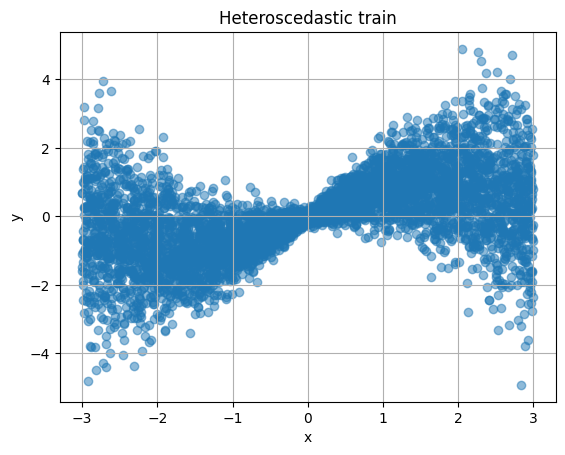

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Generate heteroscedastic data for training, validation, and testing
x_train = np.random.uniform(-3, 3, 5000)
y_train = np.sin(x_train) + np.random.normal(0, 0.1 + 0.5 * np.abs(x_train), size=x_train.shape)

x_val = np.random.uniform(-3, 3, 1000)
y_val = np.sin(x_val) + np.random.normal(0, 0.1 + 0.5 * np.abs(x_val), size=x_val.shape)

x_test = np.random.uniform(-3, 3, 1000)
y_test = np.sin(x_test) + np.random.normal(0, 0.1 + 0.5 * np.abs(x_test), size=x_test.shape)

plt.scatter(x_train, y_train, alpha=0.5)
plt.title('Heteroscedastic train')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Create classes for the two models
class HeteroscedasticNN_model_A(nn.Module):
    def __init__(self):
        super(HeteroscedasticNN_model_A, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.mean = nn.Linear(64, 1)

    def forward(self, x):
        h = self.hidden(x)
        mean = self.mean(h)
        return mean
    
class HeteroscedasticNN_model_B(nn.Module):
    def __init__(self):
        super(HeteroscedasticNN_model_B, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.mean = nn.Linear(64, 1)
        self.log_var = nn.Linear(64, 1)

    def forward(self, x):
        h = self.hidden(x)
        mean = self.mean(h)
        log_var = self.log_var(h)
        return mean, log_var

Epoch 10/100, Train Loss: 1.0509, Val Loss: 1.1224
Epoch 20/100, Train Loss: 1.0261, Val Loss: 1.1321
Epoch 30/100, Train Loss: 1.0024, Val Loss: 1.1031
Epoch 40/100, Train Loss: 0.9908, Val Loss: 1.0806
Epoch 50/100, Train Loss: 0.9758, Val Loss: 1.0712
Epoch 60/100, Train Loss: 0.9621, Val Loss: 1.0537
Epoch 70/100, Train Loss: 0.9488, Val Loss: 1.0372
Epoch 80/100, Train Loss: 0.9363, Val Loss: 1.0231
Epoch 90/100, Train Loss: 0.9258, Val Loss: 1.0091
Epoch 100/100, Train Loss: 0.9175, Val Loss: 0.9979
Epoch 10/100, Train Loss: 0.4863, Val Loss: 0.5238
Epoch 20/100, Train Loss: 0.4512, Val Loss: 0.4828
Epoch 30/100, Train Loss: 0.4110, Val Loss: 0.4415
Epoch 40/100, Train Loss: 0.3687, Val Loss: 0.4023
Epoch 50/100, Train Loss: 0.3210, Val Loss: 0.3514
Epoch 60/100, Train Loss: 0.2711, Val Loss: 0.3007
Epoch 70/100, Train Loss: 0.2264, Val Loss: 0.2549
Epoch 80/100, Train Loss: 0.1975, Val Loss: 0.2254
Epoch 90/100, Train Loss: 0.1839, Val Loss: 0.2118
Epoch 100/100, Train Loss: 0.1

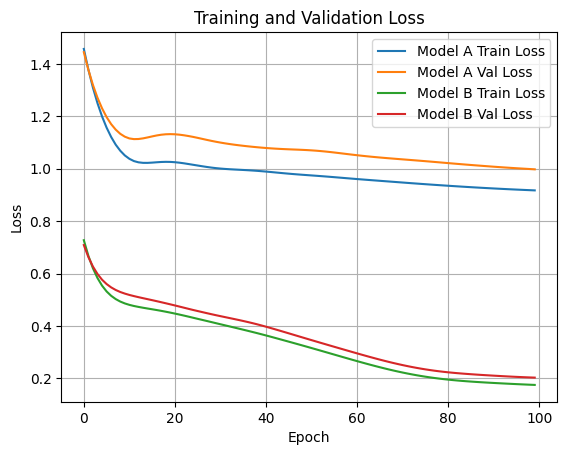

Model A Test MSE Loss: 0.9524
Model B Test NLL Loss: 0.2226
Model A Test MSE: 0.9524
Model B Test MSE (Mean Prediction): 0.9360


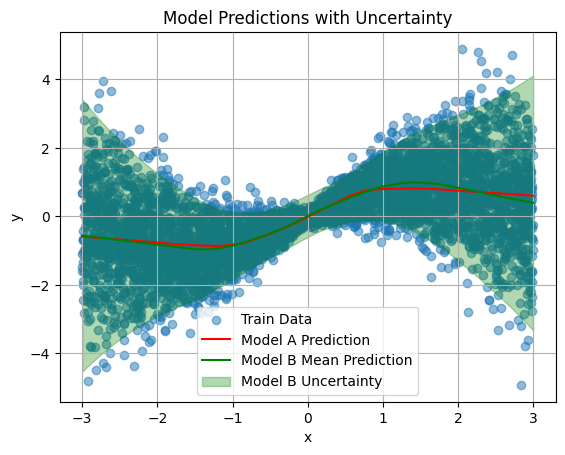

In [15]:
# Define loss functions for both models
mse_loss = nn.MSELoss()
nll_loss = nn.GaussianNLLLoss()

# Training functions for both models
def train_model_A(model, optimizer, x_train, y_train, x_val, y_val, epochs=100):
    train_losses = [] # Track training loss
    val_losses = [] # Track validation loss
    for epoch in range(epochs):
        model.train() # Set model to training mode
        optimizer.zero_grad() # Clear gradients
        outputs = model(x_train) # Forward pass
        loss = mse_loss(outputs, y_train) # Compute MSE loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        train_losses.append(loss.item()) # Store training loss
        
        model.eval() # Set model to evaluation mode
        with torch.no_grad(): # No gradient calculation for validation
            val_outputs = model(x_val) # Forward pass on validation set
            val_loss = mse_loss(val_outputs, y_val) # Compute validation loss
            val_losses.append(val_loss.item()) # Store validation loss
        
        if (epoch + 1) % 10 == 0: # Print progress every 10 epochs
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}') # Print training and validation loss
    
    return train_losses, val_losses # Return training and validation losses

def train_model_B(model, optimizer, x_train, y_train, x_val, y_val, epochs=100):
    train_losses = [] # Track training loss
    val_losses = [] # Track validation loss
    for epoch in range(epochs):
        model.train() # Set model to training mode
        optimizer.zero_grad() # Clear gradients
        mean, log_var = model(x_train) # Forward pass
        loss = nll_loss(mean, y_train, torch.exp(log_var)) # Compute NLL loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        train_losses.append(loss.item()) # Store training loss
        
        model.eval() # Set model to evaluation mode
        with torch.no_grad(): # No gradient calculation for validation
            val_mean, val_log_var = model(x_val) # Forward pass on validation set
            val_loss = nll_loss(val_mean, y_val, torch.exp(val_log_var)) # Compute validation loss
            val_losses.append(val_loss.item()) # Store validation loss
        
        if (epoch + 1) % 10 == 0: # Print progress every 10 epochs
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}') # Print training and validation loss
    
    return train_losses, val_losses # Return training and validation losses

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) # Convert to tensor and add feature dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Convert to tensor and add feature dimension
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1) # Convert to tensor and add feature dimension
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) # Convert to tensor and add feature dimension
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1) # Convert to tensor and add feature dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) # Convert to tensor and add feature dimension

model_A = HeteroscedasticNN_model_A() # Initialize Model A
optimizer_A = torch.optim.Adam(model_A.parameters(), lr=0.001) # Initialize optimizer for Model A
train_losses_A, val_losses_A = train_model_A(model_A, optimizer_A, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor) # Train Model A and get training and validation losses
model_B = HeteroscedasticNN_model_B() # Initialize Model B
optimizer_B = torch.optim.Adam(model_B.parameters(), lr=0.001) # Initialize optimizer for Model B
train_losses_B, val_losses_B = train_model_B(model_B, optimizer_B, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor) # Train Model B and get training and validation losses

plt.plot(train_losses_A, label='Model A Train Loss')
plt.plot(val_losses_A, label='Model A Val Loss')
plt.plot(train_losses_B, label='Model B Train Loss')
plt.plot(val_losses_B, label='Model B Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

model_A.eval() # Set Model A to evaluation mode
with torch.no_grad(): # No gradient calculation for testing
    test_outputs_A = model_A(x_test_tensor) # Forward pass on test set for Model A
    test_loss_A = mse_loss(test_outputs_A, y_test_tensor) # Compute MSE loss for Model A on test set
    print(f'Model A Test MSE Loss: {test_loss_A.item():.4f}') # Print Model A test loss

model_B.eval() # Set Model B to evaluation mode
with torch.no_grad(): # No gradient calculation for testing
    test_mean_B, test_log_var_B = model_B(x_test_tensor) # Forward pass on test set for Model B
    test_loss_B = nll_loss(test_mean_B, y_test_tensor, torch.exp(test_log_var_B)) # Compute NLL loss for Model B on test set
    print(f'Model B Test NLL Loss: {test_loss_B.item():.4f}') # Print Model B test loss

x_plot = np.linspace(-3, 3, 100).reshape(-1, 1) # Generate points for plotting predictions
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32) # Convert to tensor for model input

model_A.eval() # Set Model A to evaluation mode
with torch.no_grad(): # No gradient calculation for plotting
    y_plot_A = model_A(x_plot_tensor).numpy() # Get predictions from Model A and convert to numpy for plotting

model_B.eval() # Set Model B to evaluation mode
with torch.no_grad(): # No gradient calculation for plotting
    y_plot_B_mean, y_plot_B_log_var = model_B(x_plot_tensor) # Get mean and log variance predictions from Model B
    y_plot_B_mean = y_plot_B_mean.numpy() # Convert mean predictions to numpy for plotting
    y_plot_B_std = np.sqrt(np.exp(y_plot_B_log_var.numpy())) # Convert log variance to standard deviation for plotting

# Print mean squared error for both models on the test set
mse_A = mse_loss(test_outputs_A, y_test_tensor).item() # Calculate MSE for Model A on test set
mse_B = mse_loss(test_mean_B, y_test_tensor).item() # Calculate MSE for Model B mean predictions on test set
print(f'Model A Test MSE: {mse_A:.4f}') # Print Model A test MSE
print(f'Model B Test MSE (Mean Prediction): {mse_B:.4f}') # Print Model B test MSE for mean predictions

plt.scatter(x_train, y_train, alpha=0.5, label='Train Data') 
plt.plot(x_plot, y_plot_A, label='Model A Prediction', color='red')
plt.plot(x_plot, y_plot_B_mean, label='Model B Mean Prediction', color='green')
plt.fill_between(x_plot.flatten(), (y_plot_B_mean - 2 * y_plot_B_std).flatten(), (y_plot_B_mean + 2 * y_plot_B_std).flatten(), color='green', alpha=0.3, label='Model B Uncertainty')
plt.title('Model Predictions with Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

In [16]:
# Fraction of points where true value is within predicted mean ± 2 std
with torch.no_grad(): # No gradient calculation for testing
    test_mean_B, test_log_var_B = model_B(x_test_tensor) # Forward pass on test set for Model B
    test_mean_B = test_mean_B.numpy() # Convert mean predictions to numpy for coverage calculation
    test_std_B = np.sqrt(np.exp(test_log_var_B.numpy())) # Convert log variance to standard deviation for coverage calculation
    lower_bound = test_mean_B - 2 * test_std_B # Calculate lower bound of confidence interval
    upper_bound = test_mean_B + 2 * test_std_B # Calculate upper bound of confidence interval
    within_bounds = np.logical_and(y_test_tensor.numpy() >= lower_bound, y_test_tensor.numpy() <= upper_bound) # Check if true values are within the confidence interval
    coverage = np.mean(within_bounds) # Calculate coverage as the fraction of points within the confidence interval
    print(f'Model B Coverage (True value within mean ± 2 std): {coverage:.4f}') # Print coverage of Model B's confidence intervals

Model B Coverage (True value within mean ± 2 std): 0.9500


## Question 6